# **Project 03: Sustained U 235 fission**
**Name:** Raleigh Fisher 

## **Introduction**

In this project, I investigate how the multiplication factor, k, changes for Uranium 235 samples of different volumes and purities. Each sample has an initial number of neutrons, `N0`, that have a probability of being captured by a U-235 nucleus after travelling a random distance (determined by the mean free path $\lambda$). This probability is directly related to the purity of the sample, where a lower purity would lead to a lower probability of a given neutron being captured and initiating further fission. 

I examine three different classes of Uranium 235: Low-Enriched Uranium (LEU, 2-<20% U-235 content), High Assay LEU (HALEU, ~20% U-235 content), and High-Enriched Uranium (HEU, 20-90% U-235 content). By varying the volume of the cubic Uranium sample, I then characterize the relationship between k-value and volume for 3 generations of U-235 fission, as well as how uncertainties change with purity/volume. From this, I determine the most economically feasible self-sustaining U-235 fission reaction based on each purity's price and how massive the sample needs to be. 

**Research Question:** How does the purity of a uranium sample affect the volume required for a self-sustaining U-235 fission reaction? 

## **Phsyical Model & Assumptions**

Neutrons are placed uniformly inside the cube, and assigned an initial coordinate point $(x_0, y_0, z_0)$ somewhere inside the cube, for $0 < x_0, y_0, z_0 < a$

Each neutron is assigned a direction vector given by the unit sphere: $$< {\rho}^2\cos{\theta}\sin{\phi}, {\rho}^2\sin{\theta}\sin{\phi}, {\rho}^2\cos{\phi} >$$

where the vector is on the unit sphere, and $\rho = 1$

Neutrons travel a random distance before interacting, sampled from the exponential attenuation law:

$$p(L)∝e^{\textstyle -L/λ}$$

where $\lambda$ is the mean free path, which we take to be 2.65cm in this simulation

Once the neutrons have travelled a certain distance, only a fraction are captured by a U-235 nucleus and create more fission, due to the purity of the uranium sample not being 100%.  

We introduce a “purity” parameter p where:  $$P(\text{fission} \mid \text{captured}) = p $$

Each successful fission releases 2 neutrons, where :
$$ N_{\text{next}} = 2 N_{\text{last}}$$

The multiplication factor $k$ is determined by

$$
k_g = \frac{N_{i+1}}{N_i}.
$$

with the following iterpretations:

- $k < 1$: subcritical  
- $k = 1$: critical  
- $k > 1$: supercritical  

Finally, $k$ values were modelled by fitting to an exponential saturation function, where k is a function of side length a, where we expect the k value to reach some sort of steady state modelled by: $$k(a) = k_{lim} - Ae^{\frac{a}{L}}$$ where A and L are constants

#### Assumptions

1. This simulation explores the k values associated with some different real-world classifications of U-235 purities [1][2]. For this project, we examine specific chosen purities of each category:
   - Low-enriched uranium (LEU): 5% U-235 content
   - High-assay low-enriched uranium (HALEU): 20% U-235 content
   - High-enriched uranium (HEU): 54% and 80% U-235 content
2. This is a simplified model of nuclear fission, and the absorption of the neutrons into U-235 nuclei is not dependent on their energy
3. Similarly, the mean free path is 2.65cm in this simplified model
4. Each successfully absorbed neutron produces exactly 2 neutrons, which is slightly lower than the average of 2.4355 [3]
5. The number of generations has been limited to 5 as a simplification; k vs. Volume plots are used to better illustrate how k behaves asymptotically, and 5 generations generate sufficient data to qualitatively assess the subcritical/self-sustaining/supercritical nature of the sample.

## **Simulation Code**

**Code Block Summary:** This code block defines all the functions needed to run subsequent simulations. The function `intial_positions` assigns N0 coordinate points within the cube, representing each neutron. `random_directions` defines the unit direction vectors assigned to each neutron later in the simulation. `path_length` simply uses the mean_free_path to determine a random distance for the neutron to travel. The function `moves` is a simple displacement function that takes the current positions of the neutrons, and moves them by some distance (assigned by `path_length` in a random direction (assigned by `random_directions`. The function `inside_cube` identifies all the neutrons that remain inside the cube after they move. `propagate generation` utilizes the above functions to cleanly determine the final positions of the neutrons, and make note of those final positions as the spawn locations for the next neutrons. This is where the value of `purity` comes into play, as it assigns True or False to each final position, with the probability of it being True equal to the purity. Then, we eliminate all of the final positions that are false, so that only these values are used in the next generation. `run_single_simulation` runs this simulation for 3 generations and calculates a k value, and finally, `run_replications` runs this 3-generation simulation `m_replication` number of times.

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean_free_path = 2.65  # cm
n_per_fission = 2
generations = 5   # Number of generations 

# Functions 

# Generating N0 neutrons with an x,y,z within the cube
def initial_positions(N0, a):  
    x0 = np.random.uniform(0, a, N0)
    y0 = np.random.uniform(0, a, N0)
    z0 = np.random.uniform(0, a, N0)
    return np.vstack((x0, y0, z0)).T  # Combines each x,y,z entry into a bigger array

# Neutrons can travel any direction (all possible unit vectors pointing out form a sphere)
# Thats why we use the spherical coords --> assigns a random vector x,y,z that points radially
# out from the neutron
def random_directions(N):
    phi = np.random.uniform(0, 2*np.pi, N)
    costheta = np.random.uniform(-1, 1, N)
    theta = np.arccos(costheta)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = costheta

    return np.vstack((x, y, z)).T

# Get a random distance L from the exponential mean free path euation
def path_length(N, mean_free_path): 
    return np.random.exponential(mean_free_path, N)

# Moving each neutron
def moves(positions, directions, distances):
    # Moves the neutron. Also changes the shape so that we can multiply it with the direction
    return positions + distances[:, None] * directions

def inside_cube(positions, a):
    return np.all((positions >= 0) & (positions <= a), axis=1)

def propagate_generation(positions, a, mean_free_path, n_per_fission, purity):
    N = positions.shape[0]  # have to do this to set the number as N0 instead of just putting N0
    
    directions = random_directions(N)
    distances = path_length(N, mean_free_path)
    final_positions = moves(positions, directions, distances)
    mask_inside = inside_cube(final_positions, a)
    captured_positions = final_positions[mask_inside]

    # Assigning true of false to every neutron that remains in the sample, based on the purity 
    mask_fissions = np.random.rand(captured_positions.shape[0]) < purity
    fission_positions = captured_positions[mask_fissions]
    
    children_positions = np.repeat(fission_positions, n_per_fission, axis=0)

    return children_positions.shape[0], children_positions

def run_single_simulation(N0, generations=3):
    positions = initial_positions(N0, a)

    # how many neutrons remain after each generation
    Ns = [N0]
    for g in range(generations):
        N_next, next_pos = propagate_generation(positions, a, mean_free_path, n_per_fission, purity)
        Ns.append(N_next)
        positions = next_pos

    # k for each generation
    ks = []
    for i in range(generations):
        Ni, Ni1 = Ns[i], Ns[i+1]
        k = Ni1 / Ni if Ni > 0 else np.nan
        ks.append(k)

    return Ns, ks

# Repeat experiment m_replications times
def run_replications(N0, m_replications, generations):
    
    all_k = np.zeros((m_replications, generations))

    for i in range(m_replications):
        _, ks = run_single_simulation(N0, generations)
        all_k[i, :] = ks

    mean_k = np.nanmean(all_k, axis=0)
    std_k  = np.nanstd(all_k, axis=0)
    dk = std_k/np.sqrt(m_replications)

    return all_k, mean_k, std_k, dk

## Analysis of k values for HEU

### 80% U-235 HEU

**Code Block Summary:** Here, we aweep a value of side lengths `a_values` to run the simulation over, as well as defining the purity of the sample. Volumaes are calculated for each side length, and the k values across each generation are plotted as functions of both side length and volume.

Results over 300 replications:
k1 mean = 1.478 +/- 0.003
k2 mean = 1.497 +/- 0.002
k3 mean = 1.516 +/- 0.002
k4 mean = 1.518 +/- 0.002
k5 mean = 1.526 +/- 0.001
Average k value = 1.507 +/- 0.002


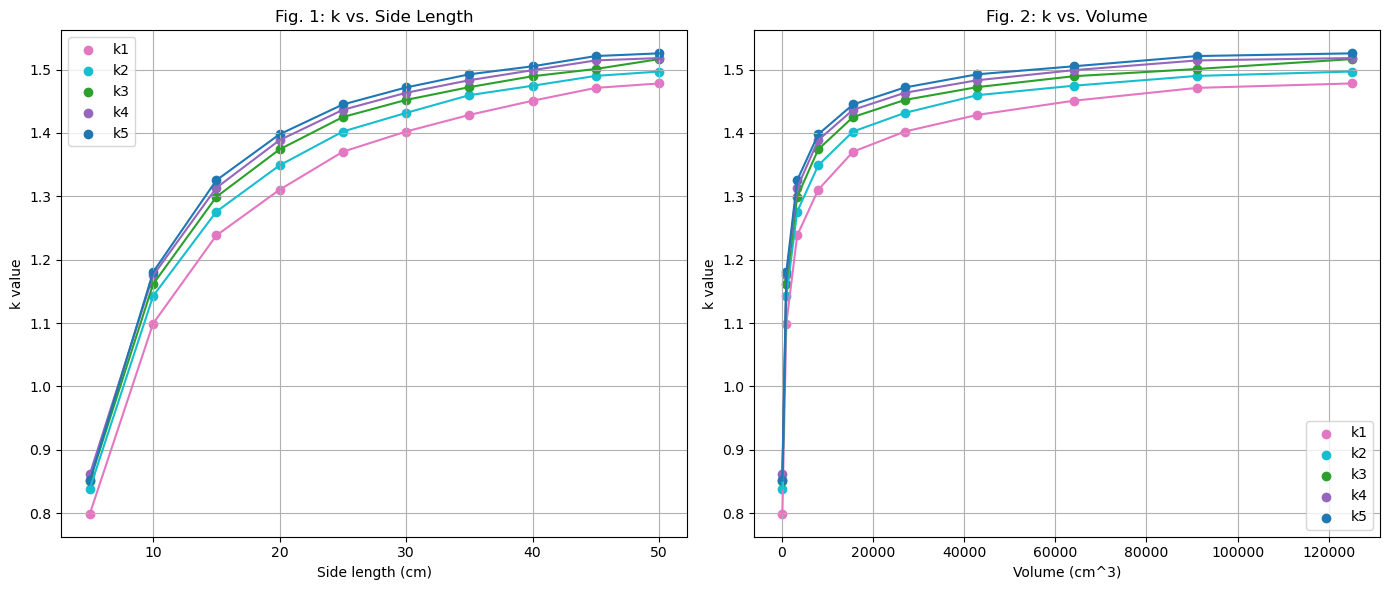

In [60]:
# Generating array of a values
a_values = np.arange(5, 55, 5)         
volumes  = a_values**3                  
purity = 0.80
N0 = 250
m_replications = 300

# Store mean_k for each generation and each side length
mean_ks_by_a = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    mean_ks_by_a.append(mean_k)

mean_ks_by_a = np.array(mean_ks_by_a) 

print("Results over", m_replications, "replications:")
for i in range(generations):
    print(f"k{i+1} mean = {mean_k[i]:.3f} +/- {dk[i]:.3f}")

k_ave = np.sum(mean_k)/len(mean_k)
dk_ave = np.sum(dk)/len(dk)
print(f"Average k value = {k_ave:.3f} +/- {dk_ave:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for k1, k2, k3
colors = ['tab:pink', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:blue']
labels = ['k1', 'k2', 'k3', 'k4', 'k5']

# k vs side length
ax = axes[0]
for gen in range(generations):
    ax.scatter(a_values, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(a_values, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Side length (cm)")
ax.set_ylabel("k value")
ax.set_title("Fig. 1: k vs. Side Length")
ax.grid(True)
ax.legend()

# k vs volume 
ax = axes[1]
for gen in range(generations):
    ax.scatter(volumes, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(volumes, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Volume (cm^3)")
ax.set_ylabel("k value")
ax.set_title("Fig. 2: k vs. Volume")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


**Fig. 1: k vs. Side Length** In this plot, we see a clean curve made by all three generations worth of k-values that resemble either a logarithm, a rational function, or an exponential saturation function. We notice that for each subsequen generation, the average k value does seem to increase slightly, but follows the same trends as its predecessors 

**Fig. 2: k vs Volume** This plot shows how quickly k value increases as a function of volume. Once again, the k values form a smooth curve, this time resembling more of a higher-order root than a logarithm, however, notice that the k values do seem to flatten out more at the top, suggesting that there is some limiting value of k that is reached. For this purity of 80%, a very expensive and very pure sample, k extends beyond 1, meaning that this reaction grows exponentially

### Fitting the Data

**Code Block Summary:** Here, we first make some emply lists of average k values and average standard deviations (taken as the uncertainties). We fill these lists lists with the values taken by loopin the simulations of our array of a values again. Then, we define a fitting function `exp_saturation_fit` and utilize `curve_fit` to fit k as a function of side length and uncertainties to an exponential saturation model

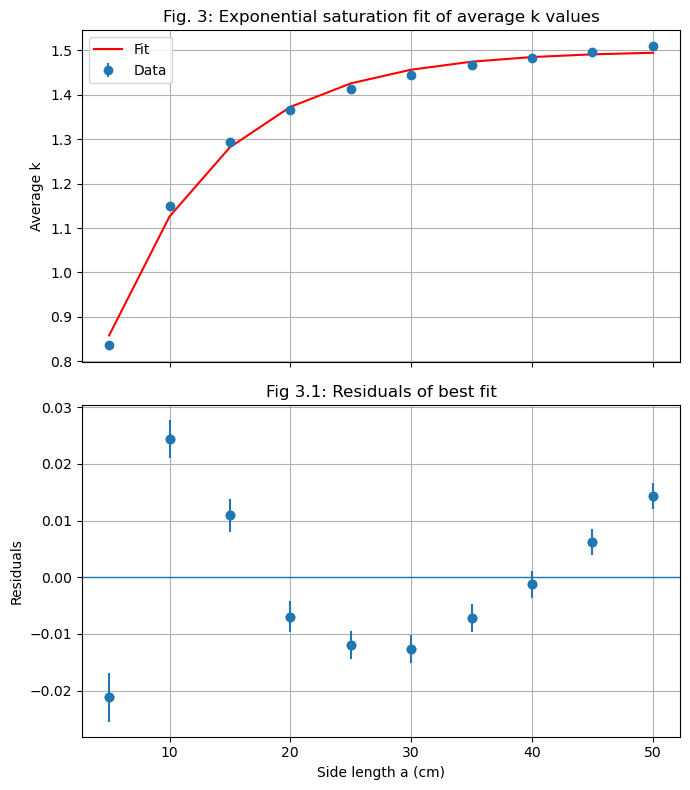

Optimized parameters [k_lim, A, L]: [1.499 +/- 0.001, 1.100, 9.256]


In [65]:
from scipy import optimize
k_aves = []
dk_aves = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    k_avg = np.mean(mean_k)        # average k across the 3 generations
    k_aves.append(k_avg)
    dk_avg = np.mean(dk)
    dk_aves.append(dk_avg)

def exp_saturation_fit(x, k_lim, A, L):
    return k_lim - A * np.exp(-x / L)

p0 = [1.5, 1, 1]  # k_inf, A, L 

yerror = dk_aves

fitparams, fitcov = optimize.curve_fit(exp_saturation_fit, a_values, k_aves, sigma=yerror, absolute_sigma=True, p0=p0)

dfitparams = np.sqrt(np.diag(fitcov))

y_fit = exp_saturation_fit(a_values, *fitparams)
residuals = k_aves - y_fit 

# Fit + residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Fitting
ax1.errorbar(a_values, k_aves, yerr=yerror, fmt='o', label='Data')
ax1.plot(a_values, y_fit, 'r-', label='Fit')
ax1.set_ylabel('Average k')
ax1.set_title('Fig. 3: Exponential saturation fit of average k values')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.axhline(0, linewidth=1)
ax2.scatter(a_values, residuals)
ax2.errorbar(a_values, residuals, yerr=yerror, fmt='o')
ax2.set_xlabel('Side length a (cm)')
ax2.set_ylabel('Residuals')
ax2.set_title('Fig 3.1: Residuals of best fit')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimized parameters [k_lim, A, L]: [{fitparams[0]:.3f} +/- {dfitparams[0]:.3f}, {fitparams[1]:.3f}, {fitparams[2]:.3f}]")

**Fig 3 & 3.1: Exponential saturation best fit & residuals plot** Here, we can see that the exponential saturation model fits the data very well. From this, we can extract the limiting k value of 1.49, which the reaction reaches asymptotically. We can also see that, for a self-sustaining reaction, the sample can be quite small, with k surpassing 1 around a = 6cm. This aligned with my expectations, as the high purity allows for a very successful reaction mechanism

### 53% U-235 HEU

Results over 300 replications:
k1 mean = 0.979 +/- 0.004
k2 mean = 0.991 +/- 0.004
k3 mean = 1.001 +/- 0.004
k4 mean = 1.005 +/- 0.004
k5 mean = 1.014 +/- 0.004
Average k value = 0.998 +/- 0.004


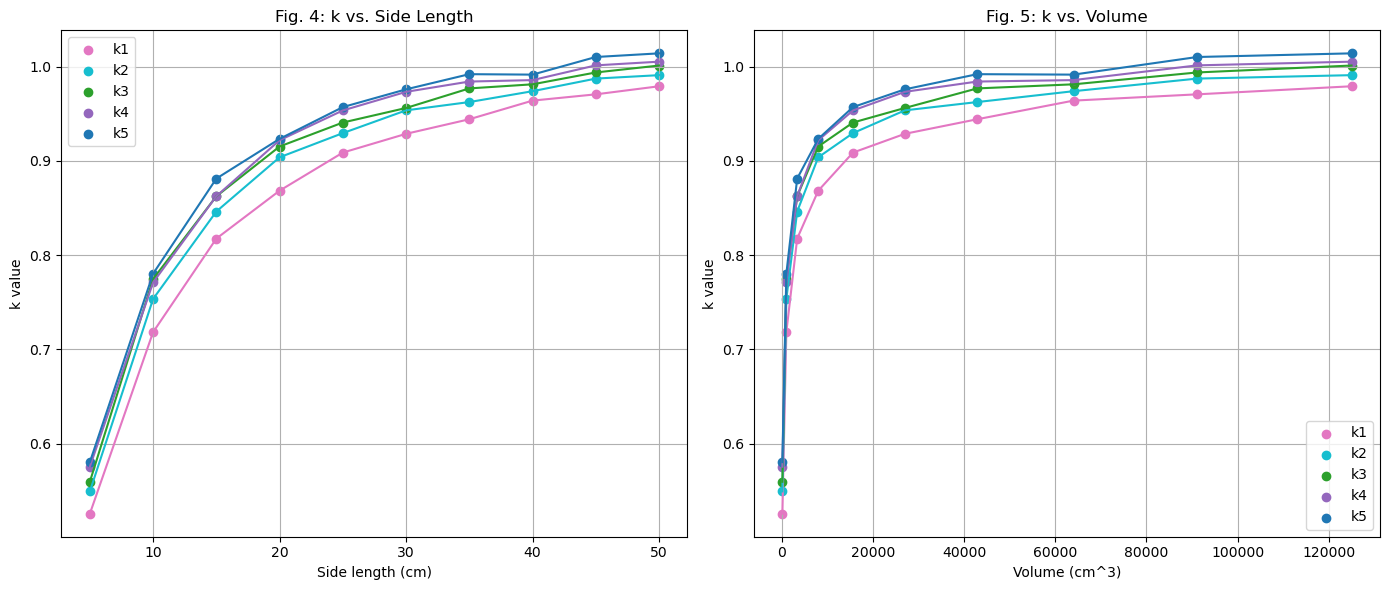

In [66]:
# Generating array of a values
a_values = np.arange(5, 55, 5)         
volumes  = a_values**3                  
purity = 0.53
N0 = 250
m_replications = 300

# Store mean_k for each generation and each side length
mean_ks_by_a = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    mean_ks_by_a.append(mean_k)

mean_ks_by_a = np.array(mean_ks_by_a) 

print("Results over", m_replications, "replications:")
for i in range(generations):
    print(f"k{i+1} mean = {mean_k[i]:.3f} +/- {dk[i]:.3f}")

k_ave = np.sum(mean_k)/len(mean_k)
dk_ave = np.sum(dk)/len(dk)
print(f"Average k value = {k_ave:.3f} +/- {dk_ave:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for k1, k2, k3
colors = ['tab:pink', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:blue']
labels = ['k1', 'k2', 'k3', 'k4', 'k5']

# k vs side length
ax = axes[0]
for gen in range(generations):
    ax.scatter(a_values, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(a_values, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Side length (cm)")
ax.set_ylabel("k value")
ax.set_title("Fig. 4: k vs. Side Length")
ax.grid(True)
ax.legend()

# k vs volume 
ax = axes[1]
for gen in range(generations):
    ax.scatter(volumes, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(volumes, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Volume (cm^3)")
ax.set_ylabel("k value")
ax.set_title("Fig. 5: k vs. Volume")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

**Fig. 4:** Here we see a slightly less smooth curve of k values, however it still follows the same pattern where each subsequent generation's k-values are slightly higher than the last. The curve of the graph is still recognizable as an exponential saturation model, so we can still fit according to that, but it may be less accurate as the k values seems to be less smooth given the lower probability of successful fissions.

**Fig 5:** Similar to Fig. 4, we see a choppier version of the Fig2 curve that resembles a higher order root function. This sample, however, has amuch lower purity, and that is reflected in the value it appears to level off at. This specific purity has been shown to demonstrate a sample whose k value levels off as self sustaining as you increase the sample size, which we can confirm numerically by fitting and extracting the optimal parameters.

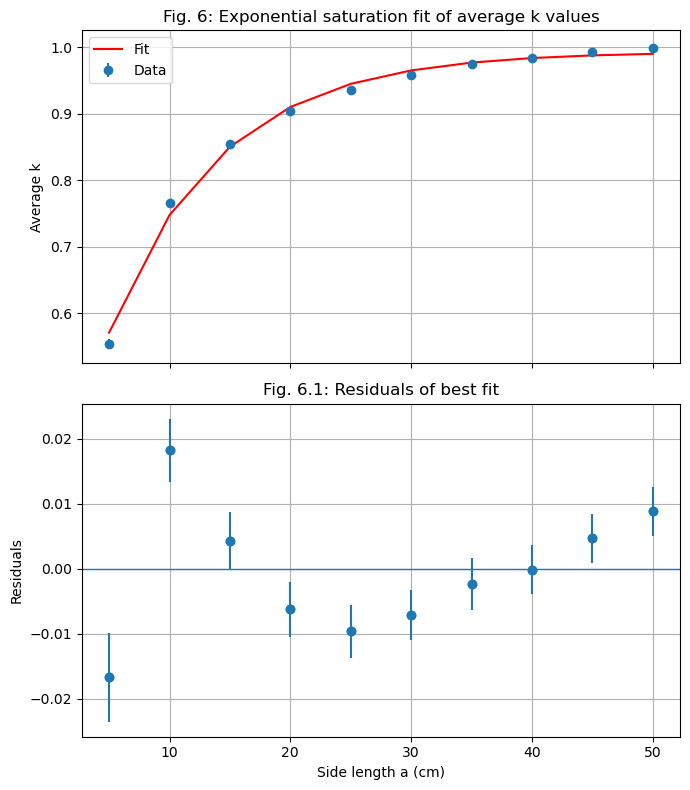

Optimized parameters [k_lim, A, L]: [0.993 +/- 0.002, 0.726, 9.224]


In [69]:
from scipy import optimize
k_aves = []
dk_aves = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    k_avg = np.mean(mean_k)        # average k across the 3 generations
    k_aves.append(k_avg)
    dk_avg = np.mean(dk)
    dk_aves.append(dk_avg)

def exp_saturation_fit(x, k_lim, A, L):
    return k_lim - A * np.exp(-x / L)

p0 = [1.5, 1, 1]  # k_inf, A, L 

yerror = dk_aves

fitparams, fitcov = optimize.curve_fit(exp_saturation_fit, a_values, k_aves, sigma=yerror, absolute_sigma=True, p0=p0)

dfitparams = np.sqrt(np.diag(fitcov))

y_fit = exp_saturation_fit(a_values, *fitparams)
residuals = k_aves - y_fit 

# Fit + residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Fitting
ax1.errorbar(a_values, k_aves, yerr=yerror, fmt='o', label='Data')
ax1.plot(a_values, y_fit, 'r-', label='Fit')
ax1.set_ylabel('Average k')
ax1.set_title('Fig. 6: Exponential saturation fit of average k values')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.axhline(0, linewidth=1)
ax2.scatter(a_values, residuals)
ax2.errorbar(a_values, residuals, yerr=yerror, fmt='o')
ax2.set_xlabel('Side length a (cm)')
ax2.set_ylabel('Residuals')
ax2.set_title('Fig. 6.1: Residuals of best fit')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimized parameters [k_lim, A, L]: [{fitparams[0]:.3f} +/- {dfitparams[0]:.3f}, {fitparams[1]:.3f}, {fitparams[2]:.3f}]")

**Fig 6 & 6.1: Exponential saturation fit & residuals for 53% HEU** From this fitted function, we can extract the limiting k value of 1.001, which shows that as the side length increases (and subsequently the volume of the sample), the reaction levels off as self sustaining, however remaining slightly exponential. Sample sizes with side lengths of around 30cm would create a long lived reaction taht eventually begins to die out, but may be considered due to the economics of acquiring a large volume of HEU. The residuals also show that the model fits the data well, as there is no clear pattern to them, however, the uncertainties are quite overestimated and thus we may get more accurate results by using a different uncertainty propagation

## Analysis of HALEU

Results over 300 replications:
k1 mean = 0.373 +/- 0.003
k2 mean = 0.372 +/- 0.004
k3 mean = 0.379 +/- 0.008
k4 mean = 0.357 +/- 0.014
k5 mean = 0.375 +/- 0.024
Average k value = 0.371 +/- 0.010


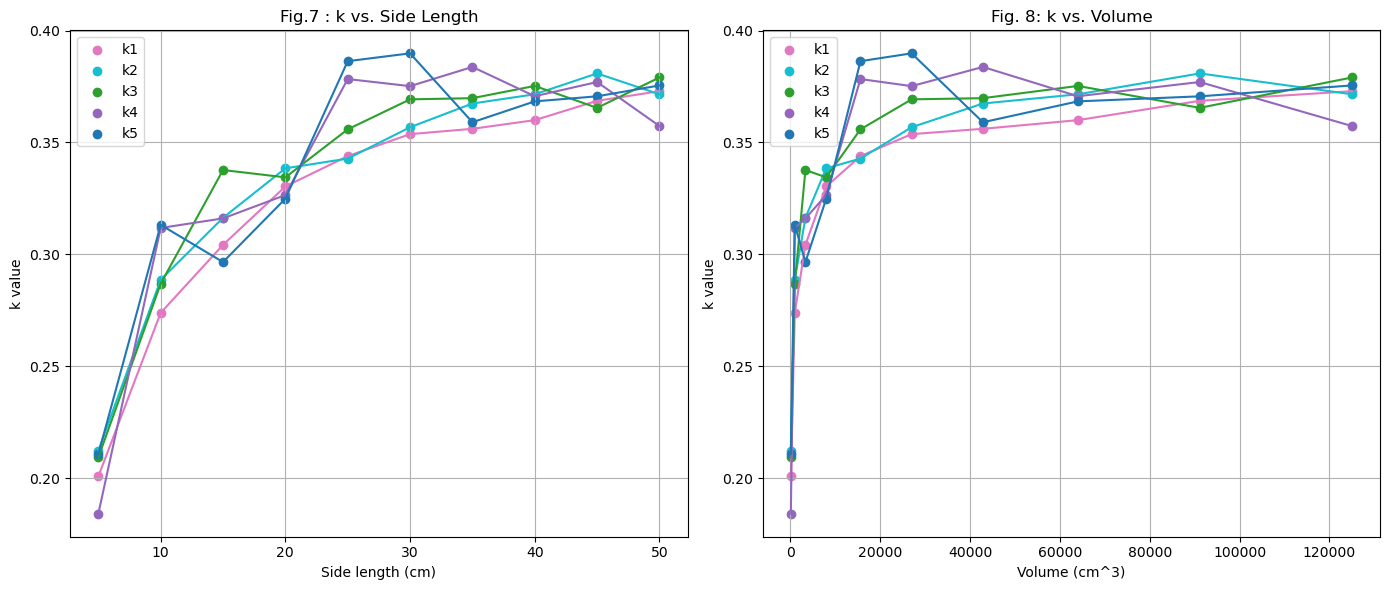

In [70]:
# Generating array of a values
a_values = np.arange(5, 55, 5)         
volumes  = a_values**3                  
purity = 0.20
N0 = 250
m_replications = 300

# Store mean_k for each generation and each side length
mean_ks_by_a = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    mean_ks_by_a.append(mean_k)

mean_ks_by_a = np.array(mean_ks_by_a) 

print("Results over", m_replications, "replications:")
for i in range(generations):
    print(f"k{i+1} mean = {mean_k[i]:.3f} +/- {dk[i]:.3f}")

k_ave = np.sum(mean_k)/len(mean_k)
dk_ave = np.sum(dk)/len(dk)
print(f"Average k value = {k_ave:.3f} +/- {dk_ave:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for k1, k2, k3
colors = ['tab:pink', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:blue']
labels = ['k1', 'k2', 'k3', 'k4', 'k5']

# k vs side length
ax = axes[0]
for gen in range(generations):
    ax.scatter(a_values, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(a_values, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Side length (cm)")
ax.set_ylabel("k value")
ax.set_title("Fig.7 : k vs. Side Length")
ax.grid(True)
ax.legend()

# k vs volume 
ax = axes[1]
for gen in range(generations):
    ax.scatter(volumes, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(volumes, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Volume (cm^3)")
ax.set_ylabel("k value")
ax.set_title("Fig. 8: k vs. Volume")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


**Fig. 7: k vs side length** Here, we see how the consistency of k drops significantly for lower purity values. This is not what I expected, however upon further inspection it does make sense that the lower probability of having a subsequent fission creates a bit more variance in the behaviour as volume changes. For this low of a purity, we also lose the pattern seen in the previous two cases, where the mean k value increased with each successive generation.

**Fig. 8: k vs Volume** This graph looks much less like a curve than both Fig. 5 and Fig. 2, however still follows the trend of k jumping up dramatically as volume increases. At this 20% purity, k levels off at a much lower value, which we confirm numerically with the exponential saturation function once again 

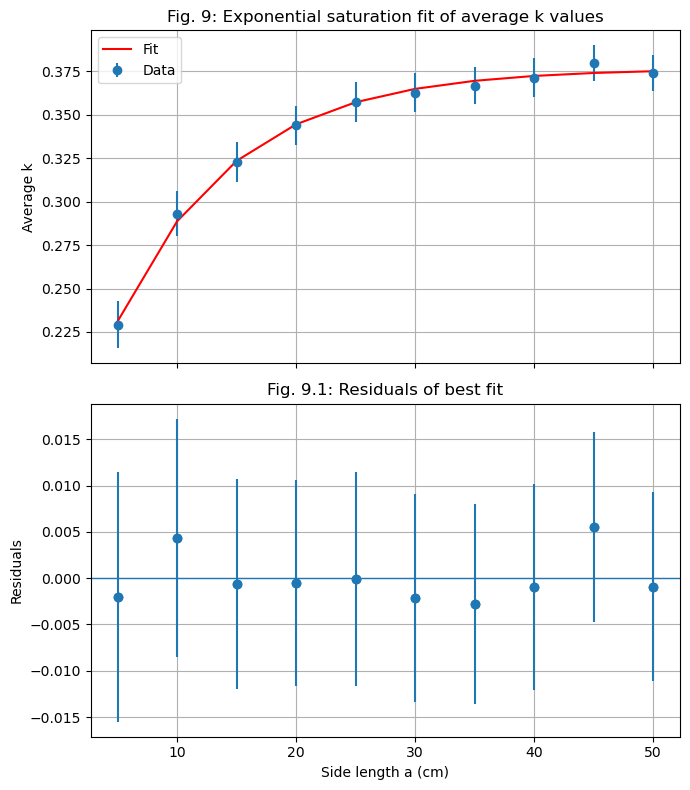

Optimized parameters [k_lim, A, L]: [0.377 +/- 0.007, 0.241, 9.926]


In [71]:
from scipy import optimize
k_aves = []
dk_aves = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    k_avg = np.mean(mean_k)        # average k across the 3 generations
    k_aves.append(k_avg)
    dk_avg = np.mean(dk)
    dk_aves.append(dk_avg)

def exp_saturation_fit(x, k_lim, A, L):
    return k_lim - A * np.exp(-x / L)

p0 = [0.371, 0.3, 9]  # k_lim, A, L 

yerror = dk_aves

fitparams, fitcov = optimize.curve_fit(exp_saturation_fit, a_values, k_aves, sigma=yerror, absolute_sigma=True, p0=p0)

dfitparams = np.sqrt(np.diag(fitcov))

y_fit = exp_saturation_fit(a_values, *fitparams)
residuals = k_aves - y_fit 

# Fit + residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Fitting
ax1.errorbar(a_values, k_aves, yerr=yerror, fmt='o', label='Data')
ax1.plot(a_values, y_fit, 'r-', label='Fit')
ax1.set_ylabel('Average k')
ax1.set_title('Fig. 9: Exponential saturation fit of average k values')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.axhline(0, linewidth=1)
ax2.scatter(a_values, residuals)
ax2.errorbar(a_values, residuals, yerr=yerror, fmt='o')
ax2.set_xlabel('Side length a (cm)')
ax2.set_ylabel('Residuals')
ax2.set_title('Fig. 9.1: Residuals of best fit')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimized parameters [k_lim, A, L]: [{fitparams[0]:.3f} +/- {dfitparams[0]:.3f}, {fitparams[1]:.3f}, {fitparams[2]:.3f}]")

**Fig 9 & 9.1: Exponential saturation best fit & residuals** The data still fits well to the exponential saturation model. which is especially evident as the residuals are evenly distributed across the model. This curve is much less dramatice, which makes sense given the lower limiting k value of 0.372. We can determine then that reactions with 20% HALEU of a smaple, no matter how large, would not be close to self sustaining and would die out fairly quickly.

## Analysis of LEU

Results over 300 replications:
k1 mean = 0.091 +/- 0.002
k2 mean = 0.097 +/- 0.005
k3 mean = 0.092 +/- 0.014
k4 mean = 0.133 +/- 0.020
Average k value = 0.103 +/- 0.010


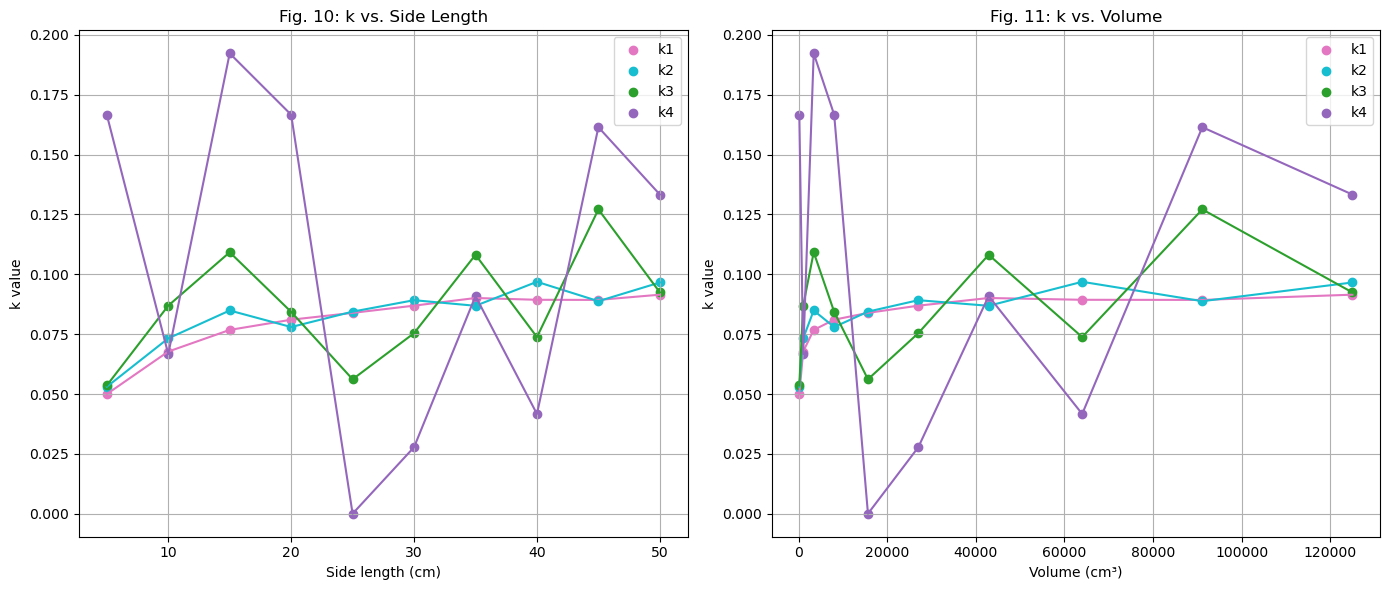

In [74]:
# Generating array of a values
a_values = np.arange(5, 55, 5)         
volumes  = a_values**3                  
purity = 0.05
N0 = 250
m_replications = 300
generations = 4

# Store mean_k for each generation and each side length
mean_ks_by_a = []

for a in a_values:
    all_k, mean_k, std_k, dk = run_replications(N0, m_replications, generations)
    mean_ks_by_a.append(mean_k)

mean_ks_by_a = np.array(mean_ks_by_a) 

print("Results over", m_replications, "replications:")
for i in range(generations):
    print(f"k{i+1} mean = {mean_k[i]:.3f} +/- {dk[i]:.3f}")

k_ave = np.sum(mean_k)/len(mean_k)
dk_ave = np.sum(dk)/len(dk)
print(f"Average k value = {k_ave:.3f} +/- {dk_ave:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for k1, k2, k3
colors = ['tab:pink', 'tab:cyan', 'tab:green', 'tab:purple', 'tab:blue']
labels = ['k1', 'k2', 'k3', 'k4', 'k5']

# k vs side length
ax = axes[0]
for gen in range(generations):
    ax.scatter(a_values, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(a_values, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Side length (cm)")
ax.set_ylabel("k value")
ax.set_title("Fig. 10: k vs. Side Length")
ax.grid(True)
ax.legend()

# k vs volume 
ax = axes[1]
for gen in range(generations):
    ax.scatter(volumes, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(volumes, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Volume (cm³)")
ax.set_ylabel("k value")
ax.set_title("Fig. 11: k vs. Volume")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

**Fig. 10: k vs side length** Here, we see how the consistency of the k values completely devolves at such a low purity. There remains a semblance of a curve, however, it is clear that the patter of increasing k value for increasing generation is broken here. In fact, the third generation seems to be the most unpredicatable generation of them all, fluctuating wildly compared to the k1 nd k2 means. This is unexpected to me, and is a very interesting result of the low purity aspect being propagated for each generation.

**Fig. 11: k vs. Volume** Here, the volume shows the same wild fluctiations, and k drops off dramatically at the end. For this analysis, the number of generations has been limited to 4, as a numpy runtime error is produced past 4 generations due to k values getting too small. This reaction, from the graph, is ostensibly not self-sustatining, and disagrees with the fitting process, causing all sorts of numerical problems. At such a low purity, we have eliminated the smooth spread of values that creates smooth curves in monte-carlo simulations, leaving only a few spotty values to work with that characterize poorly the larger physical models at play. Practically, LEU samples would not be ideal for the self-sustaining reactions.

### Heatmap of purity vs side length phase-space

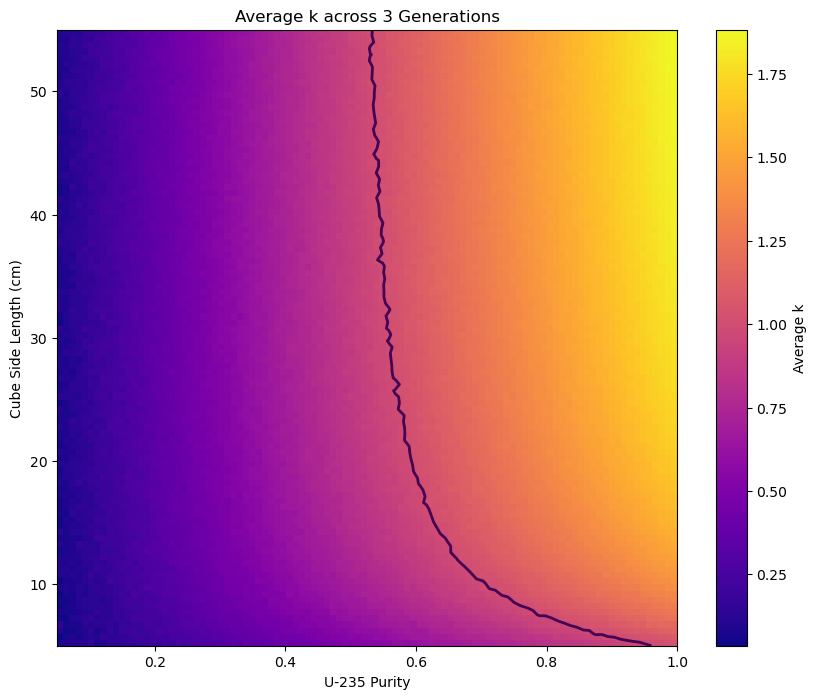

In [80]:
import numpy as np
import matplotlib.pyplot as plt

purity_values = np.linspace(0.05, 1.0, 100)   # x-axis
side_lengths  = np.linspace(5, 55, 100)       # y-axis

N0 = 200
m_replications = 40
generations = 3

K_heatmap = np.zeros((len(side_lengths), len(purity_values)))

for i, a_val in enumerate(side_lengths):
    for j, purity_val in enumerate(purity_values):
        a = a_val
        purity = purity_val

        all_k, mean_k, std_k, dk = run_replications(N0=N0, m_replications=m_replications, generations=generations)
        avg_k = np.nanmean(mean_k)
        K_heatmap[i, j] = avg_k

plt.figure(figsize=(10, 8))

plt.imshow(K_heatmap, extent=[purity_values.min(), purity_values.max(), side_lengths.min(), side_lengths.max()], cmap='plasma',
    origin="lower",
    aspect="auto")

plt.xlabel("U-235 Purity")
plt.ylabel("Cube Side Length (cm)")
plt.title("Average k across 3 Generations")

cbar = plt.colorbar()
cbar.set_label("Average k")

plt.contour(purity_values, side_lengths, K_heatmap, levels=[1], linewidths=2)

plt.show()

**Fig 12: Average k across 3 generations** A final heatmap showing the overall relationship between side length & purity, and their resulting k-values. This heatmap was plotted for only 3-generation runs, as any number of generations higher than that caused numerical problems, likely in the low purity range. A line showing k=1 has been drawn for clarity. This line is, for the most part, a nice clean curve, and resenbles an exponential decay or reciprocal relationship between the two parameters. From the plot, we can see that the range of purities is fairly narrow for large samples, however as sample size gets smaller the purity must rapidly increase to still produce a self-sustaining reaction. 

## **Summary of Results and Conclusion** 

In this project, I sought to investigate how the purity of a uranium sample affects the k-value of U-235 fission for different sample sizes. I found that both HALEU and LEU were poor candidates for self-sustaining reactions, as they both reach a limiting k value well below 1, which is required for the reaction to be self-sustaining. In analyzing higher-purity samples (HEU), I found that for purities of 54% or greater, there exists a volume large enough for the reaction to be self-sustaining. It is important to note, however, that for the 54% U-235 HEU sample, the k value reached 1 only for large a values (side lengths), requiring a very large sample for the reaction to be self-sustaining. For higher purities, such as the 80% sample analyzed, the reaction was self-sustaining for samples as small as ~36cm^3 (side length 6cm), which could be a more economical approach to achieving the self-sustaining reaction. 

## **Limitations and Next steps** 

This project includes several limitations. Energy is not considered in this project, which is a fundamental part of fission reactions, and directs the interactions between U-235 nuclei and the neutrons. Also, the sample shape was limited to a cube, as more complex shapes require the incorporation of a shape aspect, but may be more accurate to real-life scenarios. Such could be a next step, like using rectangular prism-shaped samples to mimic the rods used in nuclear reactors. Other next steps could be the addition of a probabilistic number of neutrons released from each neutron, such as a random choice function between 1-4 neutrons, and examine how that plays a role in the simulation.

## Acknowledgements
_(This section is where you acknowledge any help or support that you received in completing your project. It must include a statement regarding if and how Generative AI or other help was used in completing your project.)_

- AI helpes make the `propagate_generations` function, such as the final_position masks, and incorporate the purity as a probability in the simulation
- AI helped plot the different generation all on one plot after having run the simulation in a loop, and helped assign them all different colours by making the indexes
- AI helped make the residuals plot, however I did end up making it much simpler
- AI added the np.nan/np.nanmean/np.nanstd delegations in the simulation code, as I was getting divide by zero erorrs and didn't know how to get rid of the zero k values
- AI helped plot the k=1 line on the final heatmap

## References
*(Each reference in this section should include a citation associated with that reference in the body of your project. You may find it helpful to look at a typical Wikipedia page as an example of how to do this. Make sure you include references for source of datas, literature cited, and any python packages used beyond our standard ones. Additionally, you must also cite the sources for any code that you found on the internet or from peers.)*

* [1]https://www.sciencedirect.com/topics/engineering/enricheduranium#:~:text=Natural%20uranium%20(NU)%20is%20uranium,have%20no%20special%20security%20requirements.
* [2] https://world-nuclear.org/information-library/nuclear-fuel-cycle/conversion-enrichment-and-fabrication/high-assay-low-enriched-uranium-haleu
* [3] https://github.com/physics210/p210-2025/blob/main/docs/Project03-instructions.md

## Appendix 1: Code validation

### A1.1:
*(Note that this does not need to be, but can be, a comparison with by-hand calculations)*

Checking that 0 purity gives an error, as all of the final positions would be labelled as false and the simulation would no longer be able to run, assigning 'not a number' (nan) to k

Results over 300 replications:
k1 mean = 0.000,   std = 0.048
k2 mean = 0.000,   std = 0.078
k3 mean = nan,   std = 0.143
Average k value = nan


/tmp/ipykernel_718/778502655.py:88: RuntimeWarning: Mean of empty slice
  mean_k = np.nanmean(all_k, axis=0)


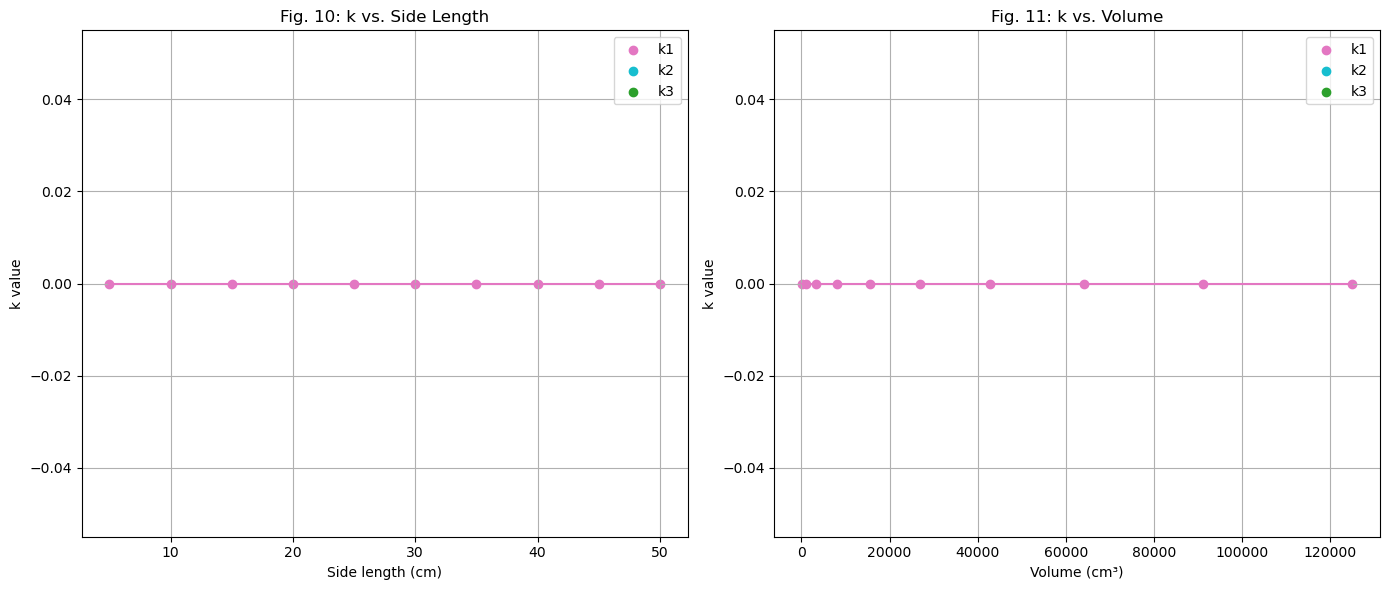

In [49]:
# Generating array of a values
a_values = np.arange(5, 55, 5)         
volumes  = a_values**3                  
purity = 0
N0 = 250
m_replications = 300

print("Results over", m_replications, "replications:")
for i in range(generations):
    print(f"k{i+1} mean = {mean_k[i]:.3f},   std = {std_k[i]:.3f}")

k_ave = np.sum(mean_k)/len(mean_k)
print(f"Average k value = {k_ave:.3f}")

# Store mean_k for each generation and each side length
mean_ks_by_a = []

for a in a_values:
    _, mean_k, _ = run_replications(N0, m_replications, generations)
    mean_ks_by_a.append(mean_k)

mean_ks_by_a = np.array(mean_ks_by_a) 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors for k1, k2, k3
colors = ['tab:pink', 'tab:cyan', 'tab:green']
labels = ['k1', 'k2', 'k3']

# k vs side length
ax = axes[0]
for gen in range(generations):
    ax.scatter(a_values, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(a_values, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Side length (cm)")
ax.set_ylabel("k value")
ax.set_title("Fig. 10: k vs. Side Length")
ax.grid(True)
ax.legend()

# k vs volume 
ax = axes[1]
for gen in range(generations):
    ax.scatter(volumes, mean_ks_by_a[:, gen], color=colors[gen], label=labels[gen])
    ax.plot(volumes, mean_ks_by_a[:, gen], color=colors[gen])

ax.set_xlabel("Volume (cm³)")
ax.set_ylabel("k value")
ax.set_title("Fig. 11: k vs. Volume")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

### A1.2: 

Making sure that the directions assigned by `random_directions` are actually isotropic, meaning that the directions of travel of the neutrons are actually completely random. I do this by running the `random_directions` function 10000 times, and then calculating the mean value of all of them. If the distribution is completely random, then since the vectors point outwards spherically, they should all cancel each other out, in a sense.

In [53]:
dirs = random_directions(10000)
print('[x ,y ,z] = ')
print(np.mean(dirs, axis=0))

[x ,y ,z] = 
[ 0.00881325  0.00083267 -0.0022616 ]


^^ These values are approximately zero, which confirms the isotropy

## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

My coding knowledge was greatly expanded by the use of functions. I think having the functions really made me realize how much it makes things easier and more streamlined. However, it was a massive learning hurdle trying to wrap my head around defining the local and global variables, what is a parameter, what changes and what doesn't, when something gets defined and when it's just a name that's stored and used when it's called. Other than that, I also became much more comfortable with the fitting mechanisms from day 16, as I essentially used my code from worksheet 16 with a few extra steps, but I was able to become a lot more familiar with it, specifically covariance and what the diagonal of that is.

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

I think that all those functions really paid off. It made things so much quicker and I was able to mess around with m_replicaitions and N0 easily without having to wait a long time for my code to run. In terms of what I could improve, I think that I could extend my knowledge of fitting even more. I think about the massive blocks of code we use to fit our data with in 219, where we use chi squared and all these other things to analyze our data, and I would have liked to incorporate those more advanced things into my project

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

I think that for the most part, my physical modelling was extented mostly through gaining familiarity with monte-carlo simulation. I have a much better understanding of probability and how different numbers of data points create different accuracies/consistencies in data spreads. for example, how the k values became much choppier as the purity of my sample went down.

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

I think that varying the purity and the volume was a cool combination, and that extracting the limiting k value from my exponential saturation fit was a great way of quantifying different purities, and determining how pure a sample needs to be to have any cahnce at all of creating a self sustaining reaction.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

I think that the communication was quite simple for the project, but still was effectve through the use of the fitting functions. I also went more in depth with the inline comment for this project, especially in teh simulation code, which I feel heightened the communication in a way the other projects didnt have.